Here, we will implement some distributed optimisation algorithms.
First, we will try the DGD Algorithm for 4 nodes. They will have optimisation objectives as follows:

$f(x) = \sum_{i = 1} ^ {4} f_i(x)
x \in \mathbb{R} ^ 4$
where

$f_i(x) = (\sum_{j \neq i}{\frac{(x ^ j) ^ 2}{6}}) + \frac{(x ^ i) ^ 2}{2}$

where $x ^ i$ is the i-th component of $x$.
We note that all the functions are convex and acheive minima identically at $(0, 0, 0, 0)$. So, in theory all $x_i$ must converge to $(0, 0, 0, 0)$

We assume the graph to be fully connected(static). The weight matrix(is doubly stochastic) will be given as : 

$W = \begin{bmatrix}
1/4 & 1/4 & 1/4 & 1/4\\
    1/4 & 1/4 & 1/4 & 1/4\\
    1/4 & 1/4 & 1/4 & 1/4\\
    1/4 & 1/4 & 1/4 & 1/4\\
    \end{bmatrix}$

The simplified DGD Algorithm works as follows:

$x_i(k + 1) = \left(sum_{j=1} ^ {4}w_{ij} \cdot x_j(k) \right)  − \alpha(k) \cdot d_i(k)$

where $x_i(k)$ is i-th node's estimate of the solution at the k-th iteration, the first term on RHS is the consensus term

$w_{ij}$ is the weight of edge j to i

$\alpha(k)$ is the learning rate at the k-th iteration

$d_i(k)$ is the subgradient for the i-th node at the k-th step at the point $x_i(k)$

We choose $\alpha(k) = 1/k$ since it is the simplest sequence satisfying the convergence requirements of the diminishing step sizes.

In our case the subgradient for node $i$ comes out to be:

$d_i ^ j(k) = \frac{1}{3} \cdot  x_i ^ j(k) \
\

    ∀ j \neq i$

$d_i ^ i(k) = x_i ^ i$

$(W \cdot X)_{ij} = \sum_{k = 1} ^ {4} w_{ik} \cdot  x_k ^ j$


In [52]:
import numpy as np

import pandas as pd
import  matplotlib.pyplot as plt
import seaborn as sbn
sbn.set_theme(style='darkgrid')


In [ ]:
def subgradient_i(i,xi):
    zer = np.zeros((4))
    zer[i] = (2/3)*xi[i]
    # print(zer + xi/3)
    return zer + xi/3

def subgradient(X):
    der = np.zeros((4,4))
    for i in range(4):
        der[i] = subgradient_i(i,X[i])
    return der

def BaseLine():
    x = np.random.rand(4,1)*24
    x = np.asarray(x,dtype = int)

    for iter in range(100):
        alpha = (float)(5.0/(iter+1.0))
        x = x - alpha*(x)*(2)
        print(f"After {iter+1} iterations: X has value")
        print(x)

def DGD():
    W = np.ones((4,4))*(1/4)
    # W = np.array([ [1/2,1/2,0,0]     --> 2 components with inner communication and no outer communication
    #               ,[1/2,1/2,0,0]
    #               ,[0,0,1/2,1/2]
    #               ,[0,0,1/2,1/2]])

    # W = np.array([ [0,1,0,0]      --> Nonsensical, no node trusts itself at all.
    #               ,[0,0,1,0]
    #               ,[0,0,0,1]
    #               ,[1,0,0,0]])

    # W = np.eye(4) --> No consensus

    print(W)
    X = np.random.rand(1,4)     # each row is the current solution for its respective node(0,1,2,3)
    X = np.repeat(X, repeats=4, axis=0)
    X = np.asarray(27*X,dtype = int)
    print("Initial Value of X")
    print(X)

    for iter in range(100):
        D = subgradient(X)
        alpha = (float)(5.0/(iter+1.0))
        X = np.dot(W,X) - alpha*D
        # print(f"D ={D}")
        print(f"After {iter+1} iterations: X has value")
        # print(X)
        print([np.linalg.norm(X[i]) for i in range(4)])

# DGD()
BaseLine()


In [35]:
def DGD(W:np.array,X:np.array,iter:np.int32,subgradient,alpha=1e-0):
    '''
    W: Doubly stochatic matrix
    X:initial solution 
    iter: Iterations

    '''

    values =[]

    for i in range(iter):
        subGradMatrix:np.array = subgradient(X)
        X= np.dot(W,X) - alpha*subGradMatrix
        values.append(X)
        if iter %5 ==0:
            alpha = alpha/2
        
    
    return np.array(values)

In [17]:
W = [[1/2, 1/2, 0, 0], [1/2, 1/2, 0, 0], [0, 0, 1/2, 1/2], [0, 0, 1/2, 1/2]]
X= (np.random.rand(4,1) - np.random.rand(4,1))*1000
Y=np.array([[1,2,3,4]]).T
np.dot(W,X)


array([[-499.98673124],
       [-499.98673124],
       [-241.65269154],
       [-241.65269154]])

In [36]:
# Assuing f(x) = x1^2 + x2^2 +x3^2 +x4^2
# and fi(x) = xi^2 , fi'(x)= 2xi
def subgradient1(X):
    return 2*X
    # Subgradiient[i] = fi'(xi)


In [64]:
values= DGD(W,X,10,subgradient1)
values[:,1].shape

(10, 1)

Text(0.5, 1.0, ' DGD Algorithm \n min F(x) = $\\sum{(x_i)^2}$ and $f_i(x) = (x_i)^2$ ')

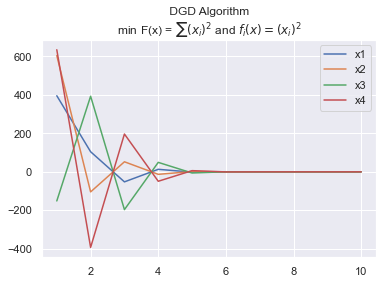

In [69]:
fig ,ax=plt.subplots()

for i in range(0,4):
    sbn.lineplot(x=np.arange(1,len(values)+1),y=np.ravel(values[:, i]),ax=ax,label=f'x{i+1}')

ax.set_title(
    ' DGD Algorithm \n min F(x) = $\sum{(x_i)^2}$ and $f_i(x) = (x_i)^2$ ')

